In [1]:
import tensorflow as tf
import pandas as pd
import bert_tf_hub
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
device = '/GPU:0' if len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
device

'/GPU:0'

# Load Data

In [3]:
dataset_path = 'data/training_dataset.csv'
dataset_df = pd.read_csv(dataset_path)
print("Shape:", dataset_df.shape)

Shape: (8795, 55)


In [4]:
text_df = dataset_df['Title']
features = dataset_df.columns[1:]
label_df = dataset_df[features]
num_classes = len(features)
print("Number of classes:", num_classes)

Number of classes: 54


In [5]:
train_text, val_text, train_label, val_label = train_test_split(text_df, label_df, test_size=0.13, random_state=37)
print(train_text.shape[0], "data for training")
print(val_text.shape[0], "data for validation")

7651 data for training
1144 data for validation


# Transform

In [6]:
# create tokenizer instance
bert_model = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2'
tokenizer = bert_tf_hub.create_tokenizer(bert_model)

In [7]:
# convert sequences into bert inputs
max_seq_length = 512
train_seq = bert_tf_hub.build_inputs(train_text, tokenizer, max_seq_length)
val_seq = bert_tf_hub.build_inputs(val_text, tokenizer, max_seq_length)

In [8]:
# convert to tf dataset
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_seq, train_label.values))
train_ds = train_ds.shuffle(train_text.shape[0] // 4).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val_seq, val_label.values))
val_ds = val_ds.shuffle(val_text.shape[0] // 4).batch(batch_size)

# Model

## Create Model

In [9]:
def build_classifier_model(num_classes, bert_model):
    inputs = bert_tf_hub.get_model_inputs()
    embedding = bert_tf_hub.get_embedding(bert_model)
    x = embedding(inputs)['sequence_output']
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='output')(x)
    return tf.keras.Model(inputs, outputs, name='bert_model')

In [10]:
# compile model
optimizer = tf.keras.optimizers.Adam(3e-5)
metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]
bert_model = build_classifier_model(num_classes, bert_model)
bert_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
bert_model.summary()

Model: "bert_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bert_embedding (KerasLayer)     {'default': (None, 1 4782465     input_2[0][0]                    
                                                                 input_3[0][0]           

## Training

In [11]:
# reduce learning rate and save model
saved_model_path = 'bert_kaidah_model.h5'
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(),
             tf.keras.callbacks.ModelCheckpoint(saved_model_path, save_best_only=True, monitor='val_accuracy')]

In [12]:
num_epoch = 100
history = bert_model.fit(train_ds, 
                         epochs=num_epoch, 
                         batch_size=batch_size, 
                         validation_data=val_ds,
                         callbacks=callbacks)

Epoch 1/100
240/240 [==============================] - 46s 166ms/step - loss: 0.2532 - accuracy: 0.4741 - auc: 0.8084 - val_loss: 0.1497 - val_accuracy: 0.4939 - val_auc: 0.8235
Epoch 2/100
240/240 [==============================] - 42s 174ms/step - loss: 0.1309 - accuracy: 0.5176 - auc: 0.8269 - val_loss: 0.1071 - val_accuracy: 0.4939 - val_auc: 0.8400
Epoch 3/100
240/240 [==============================] - 41s 169ms/step - loss: 0.0983 - accuracy: 0.5176 - auc: 0.8463 - val_loss: 0.0859 - val_accuracy: 0.4939 - val_auc: 0.8557
Epoch 4/100
240/240 [==============================] - 40s 167ms/step - loss: 0.0799 - accuracy: 0.5258 - auc: 0.8626 - val_loss: 0.0718 - val_accuracy: 0.5105 - val_auc: 0.8740
Epoch 5/100
240/240 [==============================] - 40s 166ms/step - loss: 0.0679 - accuracy: 0.5407 - auc: 0.8873 - val_loss: 0.0626 - val_accuracy: 0.5105 - val_auc: 0.9004
Epoch 6/100
240/240 [==============================] - 40s 167ms/step - loss: 0.0598 - accuracy: 0.5416 - auc:

Epoch 47/100
240/240 [==============================] - 40s 167ms/step - loss: 0.0080 - accuracy: 0.5821 - auc: 0.9996 - val_loss: 0.0194 - val_accuracy: 0.5927 - val_auc: 0.9921
Epoch 48/100
240/240 [==============================] - 40s 167ms/step - loss: 0.0079 - accuracy: 0.5838 - auc: 0.9996 - val_loss: 0.0194 - val_accuracy: 0.5909 - val_auc: 0.9924
Epoch 49/100
240/240 [==============================] - 40s 168ms/step - loss: 0.0079 - accuracy: 0.5832 - auc: 0.9995 - val_loss: 0.0193 - val_accuracy: 0.5892 - val_auc: 0.9922
Epoch 50/100
240/240 [==============================] - 40s 169ms/step - loss: 0.0078 - accuracy: 0.5811 - auc: 0.9994 - val_loss: 0.0194 - val_accuracy: 0.5918 - val_auc: 0.9921
Epoch 51/100
240/240 [==============================] - 40s 167ms/step - loss: 0.0079 - accuracy: 0.5863 - auc: 0.9995 - val_loss: 0.0194 - val_accuracy: 0.5900 - val_auc: 0.9922
Epoch 52/100
240/240 [==============================] - 40s 168ms/step - loss: 0.0079 - accuracy: 0.5853 

Epoch 93/100
240/240 [==============================] - 40s 168ms/step - loss: 0.0077 - accuracy: 0.5791 - auc: 0.9995 - val_loss: 0.0194 - val_accuracy: 0.5892 - val_auc: 0.9919
Epoch 94/100
240/240 [==============================] - 41s 169ms/step - loss: 0.0076 - accuracy: 0.5810 - auc: 0.9995 - val_loss: 0.0194 - val_accuracy: 0.5892 - val_auc: 0.9919
Epoch 95/100
240/240 [==============================] - 41s 169ms/step - loss: 0.0076 - accuracy: 0.5844 - auc: 0.9995 - val_loss: 0.0194 - val_accuracy: 0.5892 - val_auc: 0.9919
Epoch 96/100
240/240 [==============================] - 41s 169ms/step - loss: 0.0077 - accuracy: 0.5840 - auc: 0.9995 - val_loss: 0.0194 - val_accuracy: 0.5892 - val_auc: 0.9919
Epoch 97/100
240/240 [==============================] - 40s 168ms/step - loss: 0.0077 - accuracy: 0.5836 - auc: 0.9995 - val_loss: 0.0194 - val_accuracy: 0.5892 - val_auc: 0.9919
Epoch 98/100
240/240 [==============================] - 40s 168ms/step - loss: 0.0076 - accuracy: 0.5815 

## Plot Metric

In [13]:
directory = 'metric/'
if not os.path.exists(directory):
    os.mkdir(directory)

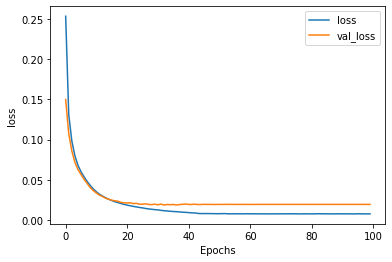

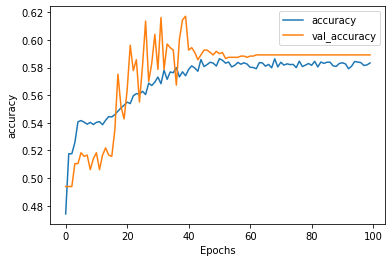

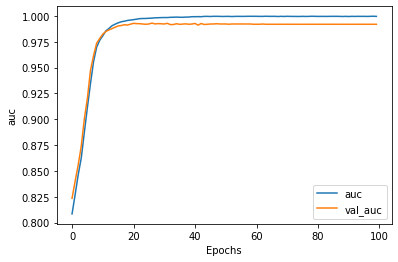

In [14]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.savefig(directory+'bert_'+string+'.png')
    plt.show()

for metric in bert_model.metrics_names:
    plot_graphs(history, metric)